In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

In [3]:
## Loading in the extracted, normalized, binned spectral light curves
## from my 'Extracting the Transmission Spectra time series' notebook
tsdata = np.load('/home/mmmurphy/data/hd219666b/reduced_data/normalizedSpectralTimeSeries.npz')
times = tsdata['times']
fluxes = tsdata['fluxes']
errors = tsdata['errors']
waves = tsdata['wavelengths']
orbit_ends = np.array([17, 34, 51])

In [5]:
print('array shape')
print(fluxes.shape)
Npoints = fluxes.shape[0]
Nwaves = fluxes.shape[1]

array shape
(51, 15)


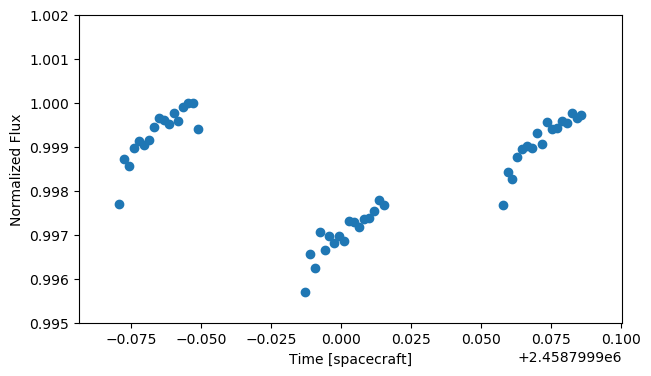

In [6]:
fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(times, fluxes[:,0])
ax.set(xlabel='Time [spacecraft]', ylabel='Normalized Flux', ylim=(0.995, 1.002))
plt.show()

In [34]:
##
# Defining my parameter arrays (inits, priors, etc)
#
# General Structure:
# 0 = tc
# 1 = log10P
# 2 = log10(a/Rstar)
# 3 = cos(i)
# 4 = Rp / Rstar
# 5 = hook model amplitude
# 6 = hook model time-scale

labels = np.asarray(['RpRs', 'amp1', 'amp2', 'amp3', 
                     'tau1', 'tau2', 'tau3', 'slope', 'intcpt'])
# Priors
lit_tc, lit_tc_unc = 2458329.1996, 0.0012   # [day; bjd tdb]
lit_P, lit_P_unc = 6.034460, 0.000011       # [day]
lit_rprs, lit_rprs_unc = 0.04192, 0.00083   # [Rstar]
lit_a, lit_a_unc = 13.27, 0.39              # [Rstar]
lit_i, lit_i_unc = 86.38, 0.15              # [degrees]
lit_Rp = 4.71          # [Rearth]
lit_e = 0.
lit_w = 90.*(np.pi/180.)  # [radian]

theta_init = np.asarray([
    # Planetary parameters
    lit_rprs,                      # 4 - HST radius
    # HST systematic parameters
    3.e-3,                      # 5 - hook amplitude for orbit 2
    3.e-3,                      # 6 - hook amplitude for orbit 3
    3.e-3,                      # 7 - hook amplitude for orbit 4
    5.e-3,                      # 8 - hook timescale for orbit 2
    5.e-3,                      # 9 - hook timescale for orbit 3
    5.e-3,                       # 10 - hook timescale for orbit 4
    0.002,                      # 11 - slope for visit-long ramp
    1.0                        # 12 - intercept for visit-long ramp
])

priors = np.asarray([
    # Planetary parameters
    np.inf,                      # 4 - HST radius
    # HST systematic parameters
    np.inf,                      # 5 - hook amplitude
    np.inf,                      # 6
    np.inf,
    np.inf,                      # 8 - hook timescales
    np.inf,
    np.inf,                       # 10 
    np.inf,
    np.inf                        # 12
])
# set those which shouldn't have a prior to have value of infinity

c = 1. / np.log(10.)
priorserr = np.asarray([
    # Planetary parameters
    lit_rprs_unc,                                         # 4 - HST radius
    # HST systematic parameters
    1.e-4,                                            # 5 - orbit 3&4 hook amplitude
    1.e-4,                                             # 6 - orbit 3&4 hook timescale
    1.e-4,                                               # 7
    1.e-4,                                             # 8
    1.e-4,                                # 9
    1.e-4,                                # 10
    1.e-3,
    1.e-5                                  # 12
])

# Initializing the BATMAN model
InitParams = batman.TransitParams()
InitParams.t0 = 2458329.201974941      
InitParams.per = 6.03447168385
InitParams.a = 13.4136
InitParams.inc = 86.4225
InitParams.rp = theta_init[0]
InitParams.ecc = 0.
InitParams.w = 90.
InitParams.limb_dark = 'quadratic'
InitParams.u = [0.33, 0.2]
BATMAN_initmodel = batman.TransitModel(InitParams, times)

In [35]:
##
# Defining my astrophysical models

def transit(theta, initmodel):
    # Transit Light curve model
    # Inputs:
    # theta = array of lightcurve parameters
    # initmodel = pre-initialized BATMAN model environment, which increases efficiency
    
    # Unpack input parameters
    tc = 2458329.201974941      # time of conjunction [days]
    #log10P = theta[1]   # log10( Period [days] )
    #log10a = theta[2]   # log10( a / Rstar )
    #cosi = theta[3]     # cosine(inclination [rad])
    rprstar = theta[0]
        
    # Transform input parameters to forms used by BATMAN
    P = 6.03447168385  # compute Period in [day]
    a = 13.4136  # compute a/Rstar
    inc =  86.4225  # Compute inclination in [deg]
    ecc = 0.    # use these if assuming circular orbit
    omega = 90.
    
    # Initialize batman parameters
    params = batman.TransitParams()
    params.t0 = tc             # transit midpoint [day]
    params.per = P    # log10 (period [day])
    params.rp = rprstar
    params.a = a      # log10 (semi major axis [Rstar])
    params.inc = inc  # cosine inclination [degrees]
    params.ecc = ecc
    params.w = omega
    
    # Using Esposito's quadratic limb darkening treatment
    params.limb_dark = 'quadratic'
    params.u = [0.33, 0.2]
    
    lightcurve = initmodel.light_curve(params)
    return lightcurve


##
# Defining my systematic models
def hook(theta):
    # Orbit-long charge trapping hook model for HST
    # Inputs:
    # theta = array of lightcurve parameters
    # torbit = time since start of corresponding orbit in units [day]
    
    amplitude_o2 = theta[1]
    amplitude_o3 = theta[2]
    amplitude_o4 = theta[3]
    
    tau_o2 = theta[4]
    tau_o3 = theta[5]
    tau_o4 = theta[6]
    
    # Pull out times [in day; MJD] of each orbit
    orbit2times = times[:orbit_ends[0]]
    orbit3times = times[orbit_ends[0] : orbit_ends[1]]
    orbit4times = times[orbit_ends[1] : orbit_ends[2]]
    
    # From above, compute time since beginning of orbit for each
    tinorbit2 = orbit2times - orbit2times[0]
    tinorbit3 = orbit3times - orbit3times[0]
    tinorbit4 = orbit4times - orbit4times[0]
    
    orbit2hook = 1.0 - amplitude_o2*np.exp(- tinorbit2 / tau_o2)
    orbit3hook = 1.0 - amplitude_o3*np.exp(- tinorbit3 / tau_o3)
    orbit4hook = 1.0 - amplitude_o4*np.exp(- tinorbit4 / tau_o4)
    
    hookcurve = np.concatenate((orbit2hook, orbit3hook, orbit4hook)) 
    return hookcurve

def ramp(theta):
    slope = theta[7]
    intcpt = theta[8]
    
    t_new = times - np.median(times)
    y = slope*t_new + intcpt
    return y

In [36]:
def logLikelihood(ydata, yerr, modely):
    
    likelihoodarray = -0.5*((ydata-modely)**2/(yerr**2)) - np.log(np.sqrt(2.*np.pi*yerr*yerr))
    lnL = np.sum(likelihoodarray)
    
    return lnL

def logPriors(theta, priors, priorserr):
    
    # Limits on certain parameters
    
    # compute priors
    lnP = 0.
    for i, priorval in enumerate(priors):
        if np.isinf(priorval):
            # If not applying a prior on a parameter, it's listed as inf in the array
            continue
        else:
            lnP += -0.5*((priorval-theta[i])**2/(priorserr[i]**2)) - np.log(np.sqrt(2.*np.pi*priorserr[i]*priorserr[i]))
    
    return lnP

def lnPosterior(theta, flux_array, unc_array):
    
    prior_array = priors
    priorerrs_array = priorserr
    #flux_array = fluxes
    #unc_array = errors
    
    # Compute and check priors
    lnPrior_value = logPriors(theta, prior_array, priorerrs_array)
    if not np.isfinite(lnPrior_value):
        return -np.inf
    
    # Compute models
    HSTtransit = transit(theta, BATMAN_initmodel)
    HSThook = hook(theta)
    HSTramp = ramp(theta)
    model = HSTtransit * HSThook * HSTramp

    # Compute likelihoods
    lnLikelihood = logLikelihood(flux_array, unc_array, model)

    # Compute posterior
    lnPost = lnPrior_value + lnLikelihood
    
    if np.isnan(lnPost):
        return -np.inf
    else:
        return lnPost

-32443.498249838256


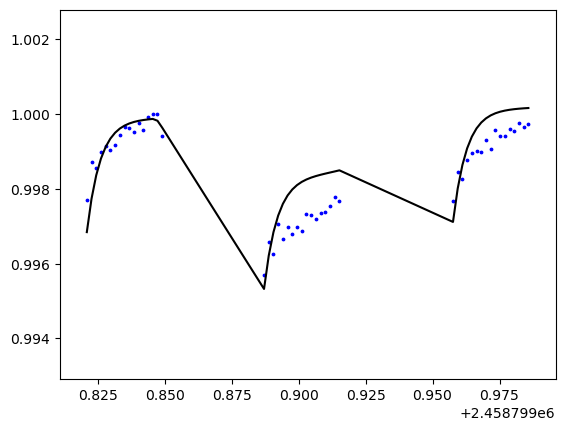

In [45]:
transit_model = transit(theta_init, BATMAN_initmodel)
hook_model = hook(theta_init)
ramp_model = ramp(theta_init)
model = transit_model * hook_model * ramp_model

lnPost_init = lnPosterior(theta_init, fluxes[:,0], errors[:,0])
print(lnPost_init)
plt.scatter(times, fluxes[:,0], c='blue', s=3)
plt.plot(times, model, c='black')
plt.show()

In [51]:
######################################
# Setting up and initializing MCMC

Ndimensions = len(theta_init)
Nwalkers = 3*Ndimensions
Nsteps = 20000

# Initializing walker positions
pos = np.zeros((Nwalkers, Ndimensions))

try:
    # if we ran this before, initialize based on previous run's best fits
    for i in range(Ndimensions):
        pos[:,i] = param_fits[i] + 0.5*np.random.normal(0., param_uperrs[i], Nwalkers)
    print('starting from previous run')
except:
    # if not, then use theta_init array
    for i in range(Ndimensions):
        pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorserr[i], Nwalkers)
    
# for i in range(Ndimensions):
#         pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorserr[i], Nwalkers)
    

starting from previous run


In [52]:
with Pool() as pool: 
    sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool,
                                args=(fluxes[:,0], errors[:,0]))
    sampler.run_mcmc(pos, Nsteps, progress=True);

100%|██████████| 20000/20000 [00:46<00:00, 433.88it/s]


In [53]:
samples = sampler.get_chain()
flatsamples = sampler.get_chain(flat=True)
loglikelihoods = sampler.get_log_prob(flat=True)
#autocorrtimes = sampler.get_autocorr_time()

burn = 1000
samples = samples[burn:]
flatsamples = flatsamples[burn*Nwalkers:]
loglikelihoods = loglikelihoods[burn*Nwalkers:]

param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])

# Generating models with best-fit parameters
bf_transit = transit(param_fits, BATMAN_initmodel)
bf_hook = hook(param_fits)
bf_ramp = ramp(param_fits)
bf_model = bf_transit * bf_hook * bf_ramp

detflux = fluxes[:,0] / bf_hook
deterrs = errors[:,0] / bf_hook

# Generating a smooth transit light curve with best-fit parameters for plotting purposes
times_smooth = np.linspace(times[0], times[-1], 100)
BFParams = batman.TransitParams()
BFParams.t0 = param_fits[0]      
BFParams.per = 10.**param_fits[1]
BFParams.a = 10.**param_fits[2]
BFParams.inc = np.arccos(param_fits[3])*(180./np.pi)
BFParams.rp = param_fits[4]
BFParams.ecc = 0.
BFParams.w = 90.
BFParams.limb_dark = 'quadratic'
BFParams.u = [0.33, 0.2]
BATMAN_smoothmodel = batman.TransitModel(BFParams, times_smooth)
transit_smooth = transit(param_fits, BATMAN_smoothmodel)

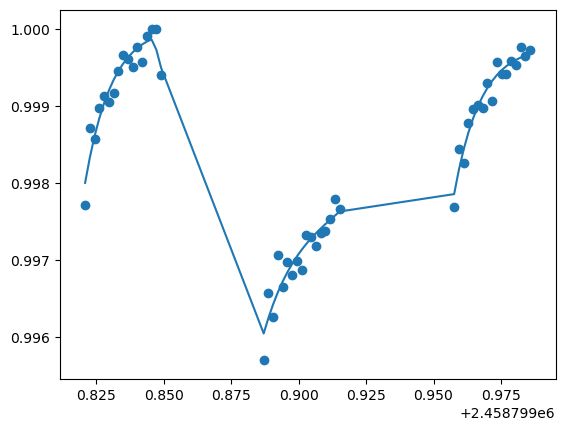

In [54]:
plt.plot(times, bf_model)
plt.scatter(times, fluxes[:,0])
plt.show()

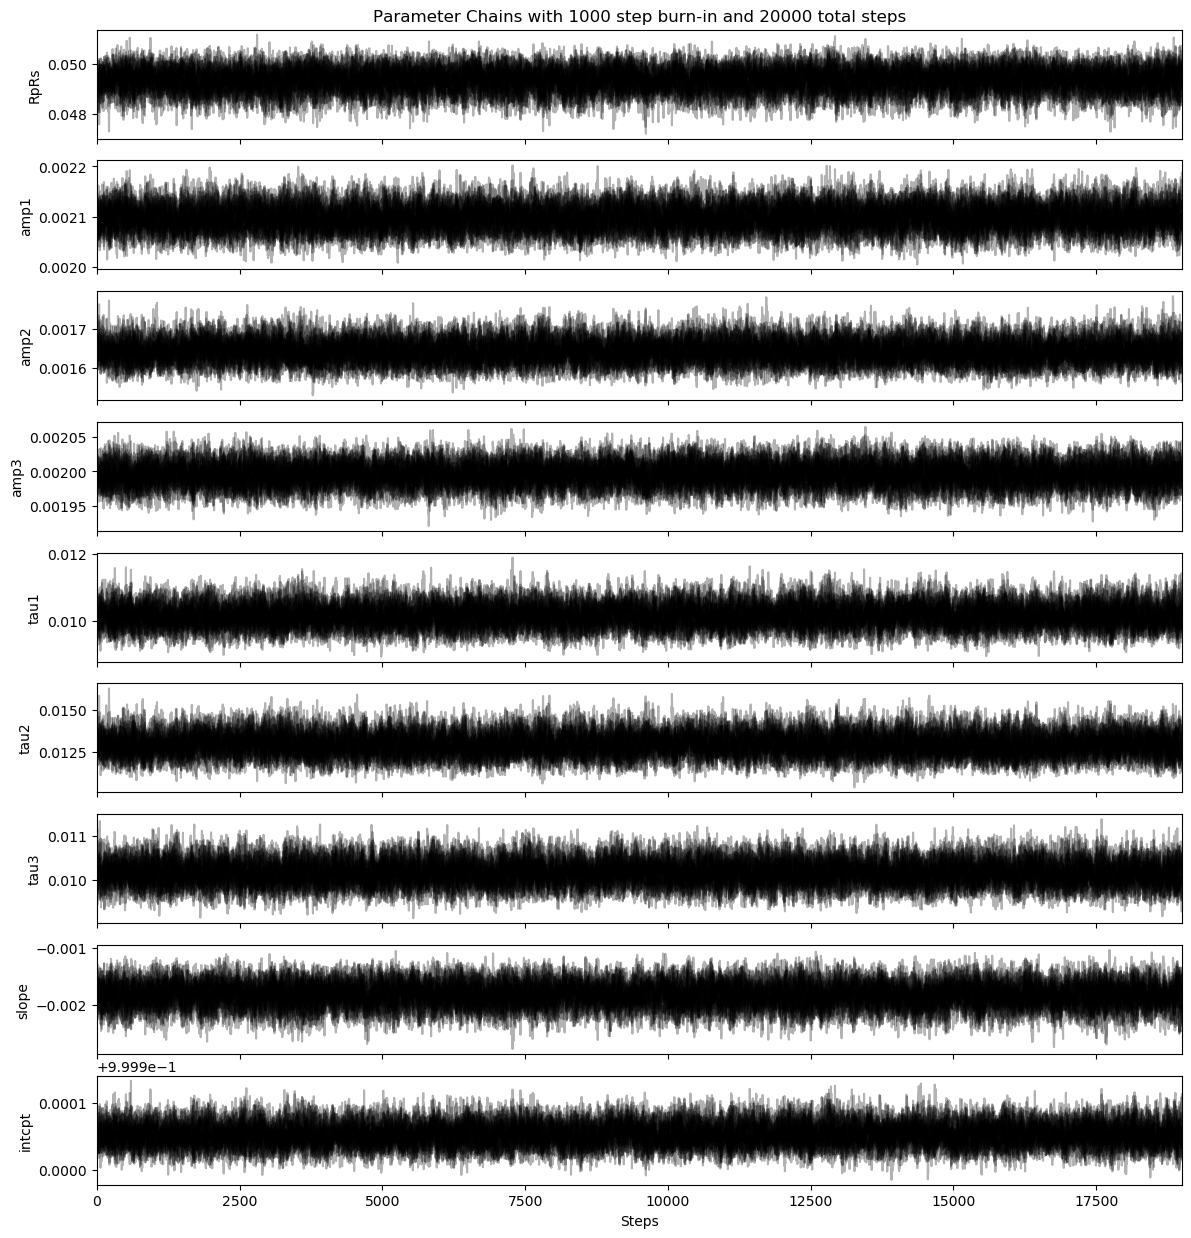

In [55]:
fig, axes = plt.subplots(samples.shape[2], figsize=(14,15), sharex=True)
for i in range(samples.shape[2]):
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.axhline(priors[i], c='blue', ls='--', alpha=0.5)
    
axes[0].set_title('Parameter Chains with %d step burn-in and %d total steps'%(burn, Nsteps))
axes[-1].set_xlabel('Steps')
#plt.savefig('figures/HSTbroadbandfit_chains.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
#cornerfig = corner.corner(flatsamples, labels=labels, show_titles=True)
#plt.show()

In [59]:
headers = ["Fit Value", "Upper error", "Lower error"]
l = []
for i, val in enumerate(labels):
    new = [labels[i], param_fits[i], param_uperrs[i], param_loerrs[i]]
    l.append(new)
    
from tabulate import tabulate    
table = tabulate(l, headers, tablefmt='orgtbl')
print('Best-Fit Fitting Parameters')
print(table)

## Computing derived parameters
# transit depth
tdepth_chain = (flatsamples[:,0]**2)*1.e6
tdepth_fit = np.median(tdepth_chain)
tdepth_uperr = np.percentile(tdepth_chain, 84) - tdepth_fit
tdepth_loerr = tdepth_fit - np.percentile(tdepth_chain, 16)
# # period [day]
# P_chain = 10.**(flatsamples[:,1])
# P_fit = np.median(P_chain)
# P_uperr = np.percentile(P_chain, 84) - P_fit
# P_loerr = P_fit - np.percentile(P_chain, 16)

derived_labels = np.asarray(['depth'])
dp_fits = np.asarray([tdepth_fit])
dp_uperrs = np.asarray([tdepth_uperr])
dp_loerrs = np.asarray([tdepth_loerr])
dl = []
for i, val in enumerate(derived_labels):
    dl.append([derived_labels[i], dp_fits[i], dp_uperrs[i], dp_loerrs[i]])
print('Derived Parameters')
table2 = tabulate(dl, headers, tablefmt='orgtbl')
print(table2)

## error statistics
print('Error Statistics')
residuals = fluxes[:,0] - bf_model
mean_residual = np.mean(abs(residuals))
print('Mean Residual = %.2f ppm'%(mean_residual*1.e6))
mean_dataerr = np.mean(errors)
print('Mean Data Error = %.2f ppm'%(mean_dataerr*1.e6))
mean_deterr = np.mean(deterrs)
print('Mean Detrended Error = %.2f ppm'%(mean_deterr*1.e6))
bf_lnPost = lnPosterior(param_fits, fluxes[:,0], errors[:,0])
print('Best Fit lnPosterior = ', bf_lnPost)

Best-Fit Fitting Parameters
|        |   Fit Value |   Upper error |   Lower error |
|--------+-------------+---------------+---------------|
| RpRs   |  0.0493812  |   0.00041552  |   0.000437929 |
| amp1   |  0.00209849 |   2.34334e-05 |   2.31499e-05 |
| amp2   |  0.00164226 |   2.75902e-05 |   2.63087e-05 |
| amp3   |  0.00199559 |   1.57213e-05 |   1.55555e-05 |
| tau1   |  0.0101557  |   0.00032487  |   0.000305048 |
| tau2   |  0.0129068  |   0.000660043 |   0.000611011 |
| tau3   |  0.0101613  |   0.000258259 |   0.00024591  |
| slope  | -0.00182457 |   0.000192659 |   0.000194312 |
| intcpt |  0.999952   |   1.65397e-05 |   1.52687e-05 |
Derived Parameters
|       |   Fit Value |   Upper error |   Lower error |
|-------+-------------+---------------+---------------|
| depth |      2438.5 |       41.2104 |       43.0591 |
Error Statistics
Mean Residual = 137.94 ppm
Mean Data Error = 20.44 ppm
Mean Detrended Error = 18.11 ppm
Best Fit lnPosterior =  -1844.4607742698545


In [60]:
# bf_lnPost = lnPosterior(param_fits)
# print('ln Posterior values:')
# print('init = ', lnPost_init)
# print('best fit = ', bf_lnPost)
# #print('ratio = ', abs(bf_lnPost)/abs(lnPost_init))

# print('error statistics')
# print('mean detrended uncertainty = ', 1.e6*np.mean(deterrs), ' ppm')

# print('mean absolute residual = ', 1.e6*np.mean(abs(residuals)), ' ppm')

fig, ax = plt.subplots(figsize=(8, 8), nrows=3, sharex=True)
plt.subplots_adjust(hspace=0.1)
ax[0].plot(times, bf_model, c='black', alpha=0.75, label='Best Fit Model')
ax[0].scatter(times, fluxes, c='blue', zorder=5, s=5, label='Observed Data')
ax[0].legend(loc='best', fontsize=8, frameon=False)
ax[0].set_ylim(0.995, 1.001)
ax[0].set_ylabel('Norm. Flux')

ax[1].plot(times_smooth, transit_smooth, c='black', alpha=0.75, label='Best Fit Transit Model')
ax[1].scatter(times, detflux, c='blue', zorder=5, s=3, label='Detrended Data')
ax[1].legend(loc='best', fontsize=8, frameon=False)
ax[1].set_ylabel('Norm. Flux')

ax[2].scatter(times, residuals*1.e6, c='blue', label='Residuals')
ax[2].axhline(0., c='black', alpha=0.5)
ax[2].set_ylabel('Residuals [ppm]')
ax[2].set_ylim(-500, 500)
ax[2].set_xlabel('Time [BJD TDB]')
ax[2].legend(loc='best', fontsize=8, frameon=False)

plt.show()

ValueError: x and y must be the same size